## Martin Dionne

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import sklearn.cluster as clu
from sklearn import preprocessing
from sklearn import metrics

# 1. k-means on digits

Use K-means clustering on the MNIST dataset (which can be imported with `from sklearn.datasets import load_digits`) to learn to identify the 10 digits in an unsupervised manner.

1. Plot the `cluster_centers_` from a kmeans clustering (which should be shape `(10,64)`) onto a `8x8` grid (hint: use `kmeans.cluster_centers_.reshape`)

2. Reorganize the clusters so that each of your learned clusters labels overlap with the true label (eg. if the digit 4 has the cluster label 9, you want to remap it to 4). Hint: You can use the statistical mode of your clusters and the real label to match them

3. Now that your cluster labels are matched to the supervised learning labels, check the classification accuracy of your clustering model (accuracy score and confusion matrix). Give a two paragraph interpretation.

4. Use the Fowlkes-Mallows score to evaluate your clustering against the true labels. Give a two paragraph interpretation comparing to your result in #3.

In [2]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py
from sklearn.datasets import load_digits
digits = load_digits(as_frame=True)

In [3]:
X = digits['data']
y = digits['target']
N_CLUSTERS = 10
kmeans = clu.KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(X)
centers = kmeans.cluster_centers_.reshape(10,8,8)

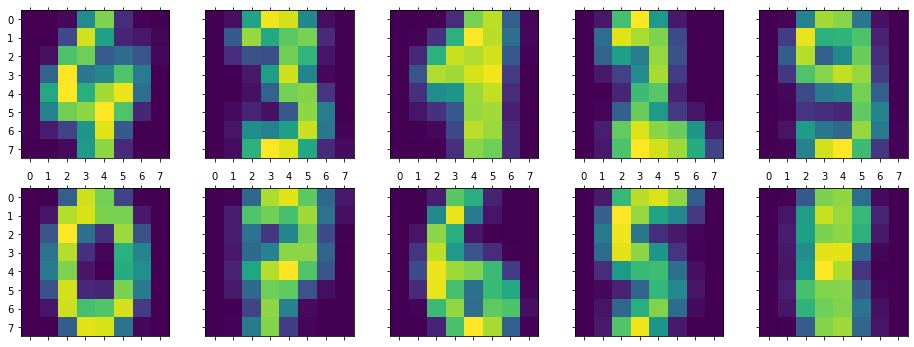

In [20]:
# 1. Plot the cluster_centers_ from a kmeans clustering

k = 0
fig, ax = plt.subplots(2, 5, sharey='row', sharex='col', figsize=(16,6))
for i in range(2):
    for j in range(5):
        ax[i, j].matshow(centers[k])
        k += 1

In [5]:
# 2. Reorganize the clusters so that each of your learned clusters labels overlap with the true label
# You can use the statistical mode of your clusters and the real label to match them

y_pred = kmeans.predict(X)
y_pred = pd.Series(y_pred).replace([0,1,2,3,4,5,6,7,8,9], [4,3,1,2,9,0,7,6,5,8])

In [6]:
# 3. check the classification accuracy of your clustering model 

print(metrics.classification_report(y, y_pred))
metrics.confusion_matrix(y_pred, y)

# An accuracy of 0.80 is good but not ideal. It means 20% of digits will be misclassified.
# The conf mat show that 3, 5 and 8 are hard to distinguish, so are 1 and 9 because of their similar shape

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       178
           1       0.60      0.30      0.40       182
           2       0.84      0.84      0.84       177
           3       0.86      0.85      0.85       183
           4       0.98      0.90      0.94       181
           5       0.91      0.75      0.82       182
           6       0.97      0.98      0.98       181
           7       0.86      0.99      0.92       179
           8       0.45      0.59      0.51       174
           9       0.57      0.77      0.66       180

    accuracy                           0.80      1797
   macro avg       0.80      0.80      0.79      1797
weighted avg       0.81      0.80      0.79      1797



array([[177,   0,   1,   0,   0,   0,   1,   0,   0,   0],
       [  0,  55,   2,   0,   7,   0,   1,   0,   6,  20],
       [  0,  24, 148,   1,   0,   0,   0,   0,   3,   0],
       [  0,   1,  13, 155,   0,   1,   0,   0,   4,   6],
       [  1,   0,   0,   0, 163,   2,   0,   0,   0,   0],
       [  0,   1,   0,   2,   0, 136,   0,   0,   4,   6],
       [  0,   2,   0,   0,   0,   1, 177,   0,   2,   0],
       [  0,   0,   3,   7,   7,   0,   0, 177,   5,   7],
       [  0,  99,   8,   7,   4,   0,   2,   2, 102,   2],
       [  0,   0,   2,  11,   0,  42,   0,   0,  48, 139]], dtype=int64)

In [7]:
# 4. Use the Fowlkes-Mallows score to evaluate your clustering

metrics.fowlkes_mallows_score(y, y_pred)

# The Fowlkes-Mallows index (FMI) is defined as the geometric mean between of the precision and recall
# FMI = TP / sqrt((TP + FP) * (TP + FN)) where T is True, F is False, P is Positive, N is Negative
# Perfect labelings are both homogeneous and complete, hence have score 1.0 
# If classes members are completely split across different clusters the FMI is 0.

# As mentionned earlier, 3, 5 and 8 are hard to distinguish, so are 1 and 9 because of their similar shape
# which affect the FMI negatively but other than that clusters are well segregated hence the value of 0.70

0.7041643183491655

# 2: Image Compression second pass

Use any the clustering algorithms we see to produce what you think is the best image compression ratio that is **visually indistinguishable** from the original image (recall in the lecture the result was very compressed but also much uglier)

Justify your choice and process in 3 paragraphs.

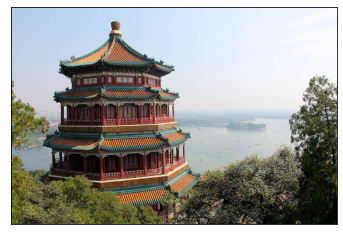

In [8]:
# Note: this requires the ``pillow`` package to be installed
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

In [9]:
# scale and rephape from (427, 640, 3) to (273280, 3)
data = china / 255.0
data = data.reshape(427 * 640, 3)

In [10]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

N_CLUSTERS = 256
model = clu.MiniBatchKMeans(N_CLUSTERS).fit(data)
#model = clu.DBSCAN(eps=0.5, min_samples=5).fit(data)
new_colors = model.cluster_centers_[model.predict(data)]

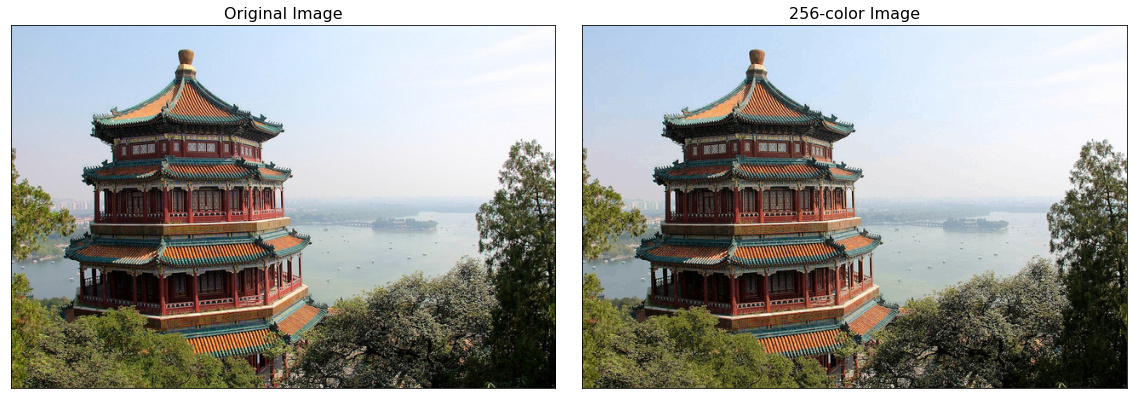

In [11]:
china_recolored = new_colors.reshape(427, 640, 3)
title = str(N_CLUSTERS) + '-color Image'

fig, ax = plt.subplots(1, 2, figsize=(20, 8),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title( title, size=16);

# 3. Clustering on Colleges

This question will use the data from `college.csv`

1. Use clustering with `k=2` on all data except whether the college is private of not. Try to match it best to the private/public college split (hint: don't forget to normalize your features!). Evaluate it in terms of classification metrics and clustering metrics.

2. Knowing what you found in `3.1`, find the best overall clustering with the k of your choice. Make an argument and a visualization of the clusters (with two relevant statistics) to demonstrate why you think your clustering is good.

In [13]:
df = pd.read_csv('data/college.csv')
df = df.drop(columns=['Unnamed: 0', 'Private'])
df

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,2197,1515,543,4,26,3089,2029,6797,3900,500,1200,60,60,21.0,14,4469,40
773,1959,1805,695,24,47,2849,1107,11520,4960,600,1250,73,75,13.3,31,9189,83
774,2097,1915,695,34,61,2793,166,6900,4200,617,781,67,75,14.4,20,8323,49
775,10705,2453,1317,95,99,5217,83,19840,6510,630,2115,96,96,5.8,49,40386,99


In [18]:
# 1. Use clustering with k=2 on all data except whether the college is private of not.
X = preprocessing.normalize(df)

N_CLUSTERS = 2
kmeans = clu.KMeans(n_clusters=N_CLUSTERS, random_state=10).fit(X)
y_pred = kmeans.fit_predict(X)

print(metrics.silhouette_score(X, y_pred))
#print(metrics.silhouette_samples(X, y_pred))

0.585803103928166


In [27]:
# 2. Find the best overall clustering with the k of your choice
nclust = [2,3,4,5,6,7,8,9,10]

for n in nclust:
    kmeans = clu.KMeans(n_clusters=n, random_state=10).fit(X)
    y_pred = kmeans.fit_predict(X)
    print(f'clusters: {n}, silhouette score: {metrics.silhouette_score(X, y_pred)}')

clusters: 2, silhouette score: 0.585803103928166
clusters: 3, silhouette score: 0.40587943308735713
clusters: 4, silhouette score: 0.3351384087651877
clusters: 5, silhouette score: 0.3071217207300303
clusters: 6, silhouette score: 0.22154358092806095
clusters: 7, silhouette score: 0.22281854243235322
clusters: 8, silhouette score: 0.20012118557933326
clusters: 9, silhouette score: 0.20297182290676705
clusters: 10, silhouette score: 0.20251048092890073


In [ ]:
# basicaly, theres is most likely 2 clusters (probably private or not)